Лабораторна Робота № 5
Ансамблі моделей для задач регресії та класифікації


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import gen_features
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report , confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


In [13]:
df_chocolate = pd.read_csv("chocolate_bars.csv")
df_co2 = pd.read_csv('CO2 Emissions_Canada.csv')
df_hyper = pd.read_csv("hypertension_data.csv")

# Підготовка для шоколадних даних

In [14]:
Ingredients = {
    "Beans": "B",
    "Sugar": "S",
    "Sweetener": "S*",
    "Cocoa Butter": "C",
    "Vanilla": "V",
    "Lecithin": "L",
    "Salt": "Sa"
}

for key in Ingredients:
    df_chocolate[key] = np.where(df_chocolate['ingredients'].str.contains(Ingredients[key],case=True), 1, 0)




asia = ['Vietnam', 'Indonesia', 'Sri Lanka', 'Malaysia', 'Philippines', 'India', 'Taiwan', 'Thailand', 'Sumatra', 'Sulawesi']
africa = ['Tanzania', 'Madagascar', 'Fiji', 'Uganda', 'Burma', 'Ghana', 'Nigeria', 'Liberia', 'Sierra Leone', 'Ivory Coast', 'Gabon', 'Sao Tome', 'Sao Tome & Principe', 'Cameroon', 'Sao Tome & Principe', 'DR Congo']
america = ['Dominican Republic', 'Venezuela', 'Peru', 'Bolivia', 'Panama', 'Colombia', 'Brazil', 'Ecuador', 'Cuba', 'Mexico', 'Nicaragua', 'Belize', 'Jamaica', 'Grenada', 'Guatemala', 'Honduras', 'Costa Rica', 'Haiti', 'Puerto Rico', 'Martinique', 'St. Lucia', 'St.Vincent-Grenadines', 'El Salvador', 'Suriname', 'DR Congo']
oceania = ['Vanuatu', 'Papua New Guinea', 'Solomon Islands', 'Samoa', 'Australia']


df_chocolate['asia'] = df_chocolate['bean_origin'].apply(lambda x: 1 if x in asia else 0)
df_chocolate['africa'] =  df_chocolate['bean_origin'].apply(lambda x: 1 if x in africa else 0)
df_chocolate['america'] =  df_chocolate['bean_origin'].apply(lambda x: 1 if x in america else 0)
df_chocolate['oceania'] =  df_chocolate['bean_origin'].apply(lambda x: 1 if x in oceania else 0)

df_chocolate['dark_choc'] = df_chocolate['cocoa_percent'].apply(lambda x: 1 if x > 60 else 0)
df_chocolate['milk_choc'] = df_chocolate['cocoa_percent'].apply(lambda x: 1 if x <= 60 else 0)


df_chocolate['rating_category'] = np.select(
    [df_chocolate['rating'].between(1, 2.50), df_chocolate['rating'].between(2.75, 3.25), df_chocolate['rating'].between(3.5, 4)],
    ['1', '2', '3'],
    default='Unknown'
)

df_chocolate.head() 

id manufacturer company_location  year_reviewed         bean_origin  \
0  2454         5150           U.S.A.           2019            Tanzania   
1  2458         5150           U.S.A.           2019  Dominican Republic   
2  2454         5150           U.S.A.           2019          Madagascar   
3  2542         5150           U.S.A.           2021                Fiji   
4  2546         5150           U.S.A.           2021           Venezuela   

                 bar_name  cocoa_percent  num_ingredients ingredients  \
0   Kokoa Kamili, batch 1           76.0              3.0       B,S,C   
1         Zorzal, batch 1           76.0              3.0       B,S,C   
2  Bejofo Estate, batch 1           76.0              3.0       B,S,C   
3   Matasawalevu, batch 1           68.0              3.0       B,S,C   
4   Sur del Lago, batch 1           72.0              3.0       B,S,C   

                              review  ...  Vanilla  Lecithin  Salt  asia  \
0          rich cocoa, fatty, bready  ...        0         0     0     0   
1             cocoa, vegetal, savory  ...        0         0     0     0   
2       cocoa, blackberry, full body  ...        0         0     0     0   
3                chewy, off, rubbery  ...        0         0     0     0   
4  fatty, earthy, moss, nutty,chalky  ...        0         0     0     0   

   africa  america  oceania  dark_choc  milk_choc  rating_category  
0       1        0        0          1          0                2  
1       0        1        0          1          0                3  
2       1        0        0          1          0                3  
3       1        0        0          1          0                2  
4       0        1        0          1          0                2  

[5 rows x 25 columns]

In [15]:
df_co2

Make        Model   Vehicle Class  Engine Size(L)  Cylinders  \
0     ACURA          ILX         COMPACT             2.0          4   
1     ACURA          ILX         COMPACT             2.4          4   
2     ACURA   ILX HYBRID         COMPACT             1.5          4   
3     ACURA      MDX 4WD     SUV - SMALL             3.5          6   
4     ACURA      RDX AWD     SUV - SMALL             3.5          6   
...     ...          ...             ...             ...        ...   
7380  VOLVO  XC40 T5 AWD     SUV - SMALL             2.0          4   
7381  VOLVO  XC60 T5 AWD     SUV - SMALL             2.0          4   
7382  VOLVO  XC60 T6 AWD     SUV - SMALL             2.0          4   
7383  VOLVO  XC90 T5 AWD  SUV - STANDARD             2.0          4   
7384  VOLVO  XC90 T6 AWD  SUV - STANDARD             2.0          4   

     Transmission Fuel Type  Fuel Consumption City (L/100 km)  \
0             AS5         Z                               9.9   
1              M6         Z                              11.2   
2             AV7         Z                               6.0   
3             AS6         Z                              12.7   
4             AS6         Z                              12.1   
...           ...       ...                               ...   
7380          AS8         Z                              10.7   
7381          AS8         Z                              11.2   
7382          AS8         Z                              11.7   
7383          AS8         Z                              11.2   
7384          AS8         Z                              12.2   

      Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                                 6.7                               8.5   
1                                 7.7                               9.6   
2                                 5.8                               5.9   
3                                 9.1                              11.1   
4                                 8.7                              10.6   
...                               ...                               ...   
7380                              7.7                               9.4   
7381                              8.3                               9.9   
7382                              8.6                              10.3   
7383                              8.3                               9.9   
7384                              8.7                              10.7   

      Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                              33                  196  
1                              29                  221  
2                              48                  136  
3                              25                  255  
4                              27                  244  
...                           ...                  ...  
7380                           30                  219  
7381                           29                  232  
7382                           27                  240  
7383                           29                  232  
7384                           26                  248  

[7385 rows x 12 columns]

# Підготовка до СО2

In [16]:
    Q1 = df_co2['CO2 Emissions(g/km)'].quantile(0.25)
    Q3 = df_co2['CO2 Emissions(g/km)'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlaier = ((df_co2['CO2 Emissions(g/km)']<lower_bound)|(df_co2['CO2 Emissions(g/km)']>upper_bound)).sum()
    print(outlaier)
    df_co2 = df_co2.loc[(df_co2['CO2 Emissions(g/km)'] >= lower_bound) & (df_co2['CO2 Emissions(g/km)'] <= upper_bound)]
    
    outlaier = ((df_co2['CO2 Emissions(g/km)']<lower_bound)|(df_co2['CO2 Emissions(g/km)']>upper_bound)).sum()
    print(outlaier)

df_co2 = df_co2.dropna(subset=['Fuel Type'])
df_co2 = df_co2[df_co2['Fuel Type'] != 'N']

80
0


In [17]:
df_со2copy = df_co2.copy()
columns_to_encode = ['Make', 'Vehicle Class', 'Cylinders', 'Transmission', 'Fuel Type']

for column in columns_to_encode:
    binary_encoded = pd.get_dummies(df_co2[column], prefix=column)
    df_со2copy = pd.concat([df_со2copy, binary_encoded], axis=1)
    df_со2copy.drop(column, axis=1, inplace=True)

In [18]:
df_со2copy.drop(columns=['CO2 Emissions(g/km)', 'Model'], inplace=True)  

# Підготовка до Гіпертензії

# Завдання 1. Bagging для мультикласової класифікації (випадкові ліси):

In [19]:
X = df_chocolate.drop(['rating','rating_category', 'manufacturer', 'id', 'bar_name', 'company_location', 'ingredients', 'bean_origin', 'review', 'year_reviewed'], axis=1)
y = df_chocolate['rating_category']


X_train_lr4, X_test_lr4, y_train_lr4, y_test_lr4 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_features = gen_features(
    columns=[[col] for col in df_chocolate.drop(['rating','rating_category', 'manufacturer', 'id', 'bar_name', 'company_location', 'ingredients', 'bean_origin', 'review', 'year_reviewed'], axis=1)[['cocoa_percent','num_ingredients']].columns],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'},
        {'class': StandardScaler}
    ]
)
categorical_features = gen_features(
    columns=[[col] for col in df_chocolate.drop(['rating','rating_category', 'manufacturer', 'id', 'bar_name', 'company_location', 'ingredients', 'bean_origin', 'review', 'year_reviewed'], axis=1).columns if col not in ['cocoa_percent', 'num_ingredients']]
)

mapper = DataFrameMapper(
  numerical_features + categorical_features, df_out= True, default=False)

X_train_prepr_lr4 = mapper.fit_transform(X_train_lr4)
X_test_prepr_lr4 = mapper.transform(X_test_lr4)

In [20]:
rfc = RandomForestClassifier()

param_dist = {
    'n_estimators': randint(100, 1000),  # Кількість дерев
    'max_features': ['auto', 'sqrt'],  # Максимальна кількість ознак для розгляду на кожному розбитті
    'max_depth': randint(5, 30),  # Максимальна глибина дерев
    'min_samples_split': randint(2, 10),  # Мінімальна кількість вибірок для розгляду вузла
    'min_samples_leaf': randint(1, 5)  # Мінімальна кількість вибірок для листя
}

grid_search_rfc = GridSearchCV(rfc, params, cv=5)
grid_search_rfc.fit(X_train_prepr_lr4, y_train_lr4)

print("Найкращі параметри:", grid_search_rfc.best_params_)

Найкращі параметри: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [21]:
y_pred_rfc = grid_search_rfc.predict(X_test_prepr_lr4)

accuracy_rfc = accuracy_score(y_test_lr4, y_pred_rfc)
precision_rfc = precision_score(y_test_lr4, y_pred_rfc, average='weighted')
recall_rfc = recall_score(y_test_lr4, y_pred_rfc, average='weighted')
f1_rfc = f1_score(y_test_lr4, y_pred_rfc, average='weighted')

print("Accuracy:", accuracy_rfc)
print("Precision:", precision_rfc)
print("Recall:", recall_rfc)
print("F1 Score:", f1_rfc)

print("Classification Report:")
print(classification_report(y_test_lr4, y_pred_rfc))


Accuracy: 0.525691699604743
Precision: 0.5665904725621854
Recall: 0.525691699604743
F1 Score: 0.3764039401201332
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.04      0.08        47
           2       0.52      0.99      0.69       264
           3       0.60      0.02      0.03       195

    accuracy                           0.53       506
   macro avg       0.60      0.35      0.27       506
weighted avg       0.57      0.53      0.38       506


                        Accuracy  Precision    Recall  F1 Score
KNN                     0.501976   0.468990  0.501976  0.472361
SGDClassifier           0.531621   0.341996  0.531621  0.378401
DecisionTreeClassifier  0.523715   0.508032  0.523715  0.512730

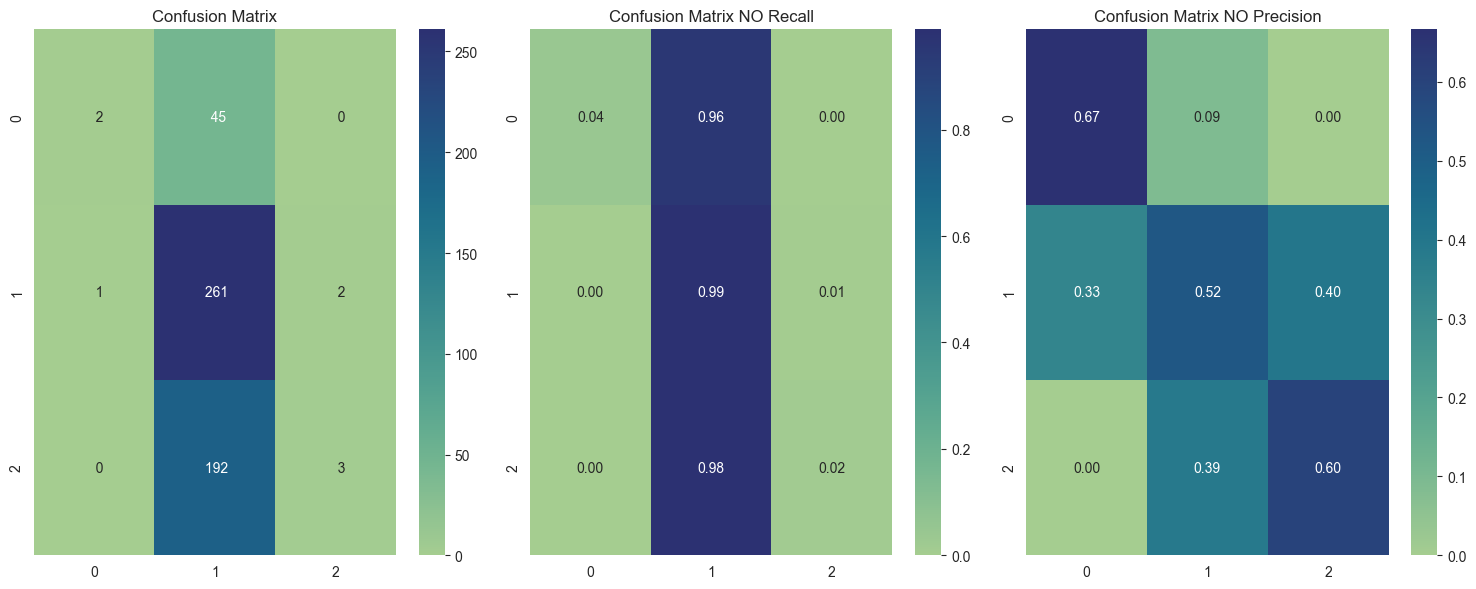

Confusion Matrix (KNN):
 [[  2  45   0]
 [  1 261   2]
 [  0 192   3]]

Confusion Matrix (Normalized - Recall):
 [[0.04255319 0.95744681 0.        ]
 [0.00378788 0.98863636 0.00757576]
 [0.         0.98461538 0.01538462]]

Confusion Matrix (Normalized - Precision):
 [[0.66666667 0.09036145 0.        ]
 [0.33333333 0.52409639 0.4       ]
 [0.         0.38554217 0.6       ]]


In [22]:
conf_matrix_rfc = confusion_matrix(y_test_lr4, y_pred_rfc)

conf_matrix_normalized_recall_rfc = confusion_matrix(y_test_lr4, y_pred_rfc, normalize='true')
conf_matrix_normalized_precision_rfc = confusion_matrix(y_test_lr4, y_pred_rfc, normalize='pred')


fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.heatmap(conf_matrix_rfc, annot=True, fmt="4.0f", cmap="crest", ax=axes[0])
axes[0].set_title("Confusion Matrix")
#по recall
sns.heatmap(conf_matrix_normalized_recall_rfc, annot=True, fmt=".2f", cmap="crest",ax=axes[1])
axes[1].set_title("Confusion Matrix NO Recall")
#по precision
sns.heatmap(conf_matrix_normalized_precision_rfc, annot=True, fmt=".2f", cmap="crest",ax=axes[2])
axes[2].set_title("Confusion Matrix NO Precision")
plt.tight_layout()
plt.show()

print("Confusion Matrix (KNN):\n", conf_matrix_rfc)
print("\nConfusion Matrix (Normalized - Recall):\n", conf_matrix_normalized_recall_rfc)
print("\nConfusion Matrix (Normalized - Precision):\n", conf_matrix_normalized_precision_rfc)

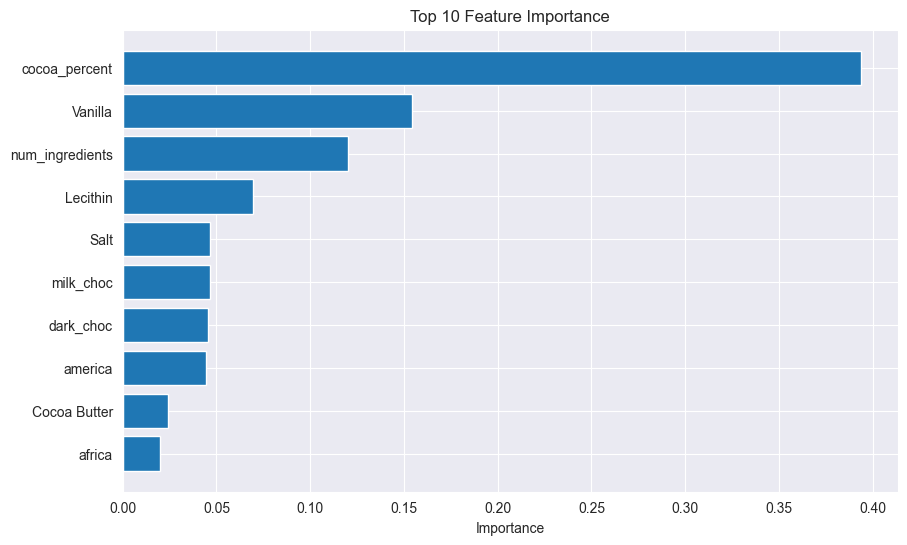

In [23]:
feature_importance = grid_search_rfc.best_estimator_.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train_prepr_lr4.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.show()


# Завдання 2. Градієнтний бустинг для задач з вчителем:

Розв’язати задачу регресії на датасеті з 2 ЛР, використовуючи бустинг-регресор [API: 1]. Обчислити метрики, задані у відповідній лабораторній роботі. Вивести порівняльну таблицю результатів лінійної регресії (кращої з усіх навчених в ЛР 2) та результатів бустинг моделі;


In [24]:
feature = df_со2copy
labels = df_co2['CO2 Emissions(g/km)']

X_train_lr2, X_test_lr2, y_train_lr2, y_test_lr2 = train_test_split(feature, labels, test_size = 0.2, random_state = 0)

In [25]:
numeric_features = ['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 
                    'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 
                    'Fuel Consumption Comb (mpg)']
categorical_features = [col for col in feature.columns if col not in numeric_features]

X_train_numeric = X_train_lr2[numeric_features]
X_test_numeric = X_test_lr2[numeric_features]
X_train_categorical = X_train_lr2[categorical_features]
X_test_categorical = X_test_lr2[categorical_features]

scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

X_train_scaled_lr2 = np.concatenate((X_train_numeric_scaled, X_train_categorical.values), axis=1)
X_test_scaled_lr2 = np.concatenate((X_test_numeric_scaled, X_test_categorical.values), axis=1)


In [26]:
lgbm_model = LGBMRegressor(random_state=0)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}


grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled_lr2, y_train_lr2)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 3895, number of used features: 85
[LightGBM] [Info] Start training from score 247.913222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 3895, number of used features: 84
[LightGBM] [Info] Start training from score 248.645700


G:\Ilya\ML\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "G:\Ilya\ML\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 3896, number of used features: 84
[LightGBM] [Info] Start training from score 248.590606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 3895, number of used features: 85
[LightGBM] [Info] Start training from score 247.913222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [27]:
y_pred_lgbm = grid_search.predict(X_test_scaled_lr2)

def print_metrics(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r_squared = r2_score(y_test, predictions)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R²:", r_squared)

print_metrics(y_test_lr2, y_pred_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean Absolute Error (MAE): 1.870537310268133
Mean Squared Error (MSE): 6.1545484109325805
R²: 0.9979331932695605


  Model        MAE         MSE        R²
0  Lineal   2.799725   20.643098  0.993068
1    Top3  12.577699  409.028384  0.862641
2   Lasso   3.120425   23.353214  0.992158
3   Ridge   2.800492   20.620049  0.993075

# Розв’язати задачу бінарної класифікації на датасеті з 3 ЛР, 
використовуючи бустинг- класифікатор [API: 2]. Обчислити метрики, задані у відповідній лабораторній роботі. Вивести порівняльну таблицю результатів лінійної регресії (кращої з усіх навчених в ЛР 3) та результатів бустинг моделі;

In [28]:
X = df_hyper.drop('target', axis=1)
y = df_hyper['target']

X_train_lr3, X_test_lr3, y_train_lr3, y_test_lr3 = train_test_split(X, y, test_size=0.4, random_state=42)

numerical_features = gen_features(
    columns=[
        ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],
    ],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'},
        {'class': StandardScaler},
    ]
)
categorical_features = gen_features(
    columns=[
        ['sex', 'fbs', 'exang'],
        ['slope', 'ca', 'thal', 'restecg', 'cp'],
    ],
        classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'},
        {'class': OneHotEncoder},
    ]
)

mapper = DataFrameMapper(
  numerical_features + categorical_features, df_out= True, default=False)

X_train_prepr_lr3 = mapper.fit_transform(X_train_lr3)
X_test_prepr_lr3 = mapper.transform(X_test_lr3)

In [29]:
lgbm_clf = LGBMClassifier(random_state=42)

param_dist = {
    'n_estimators': sp_randint(50, 200),
    'max_depth': sp_randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9], 
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],

}

rand_search = RandomizedSearchCV(lgbm_clf, param_distributions=param_dist,
                                 n_iter=100, cv=5, scoring='accuracy',
                                 random_state=42, n_jobs=-1)

rand_search.fit(X_train_prepr_lr3, y_train_lr3)

print("Кращі гіперпараметри для LightGBM:", rand_search.best_params_)
print("Найкращий score для LightGBM:", rand_search.best_score_)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8560, number of negative: 7089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 15649, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547000 -> initscore=0.188556
[LightGBM] [Info] Start training from score 0.188556
Кращі гіперпараметри для LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 149, 'subsample': 0.9}
Найкращий score для LightGBM: 1.0


In [30]:
y_pred_lgbm_clf = rand_search.predict(X_test_prepr_lr3)

accuracy = accuracy_score(y_test_lr3, y_pred_lgbm_clf)
print(f"Accuracy: {accuracy}")

# Generate and print the classification report
class_report = classification_report(y_test_lr3, y_pred_lgbm_clf)
print(class_report)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4720
           1       1.00      1.00      1.00      5714

    accuracy                           1.00     10434
   macro avg       1.00      1.00      1.00     10434
weighted avg       1.00      1.00      1.00     10434


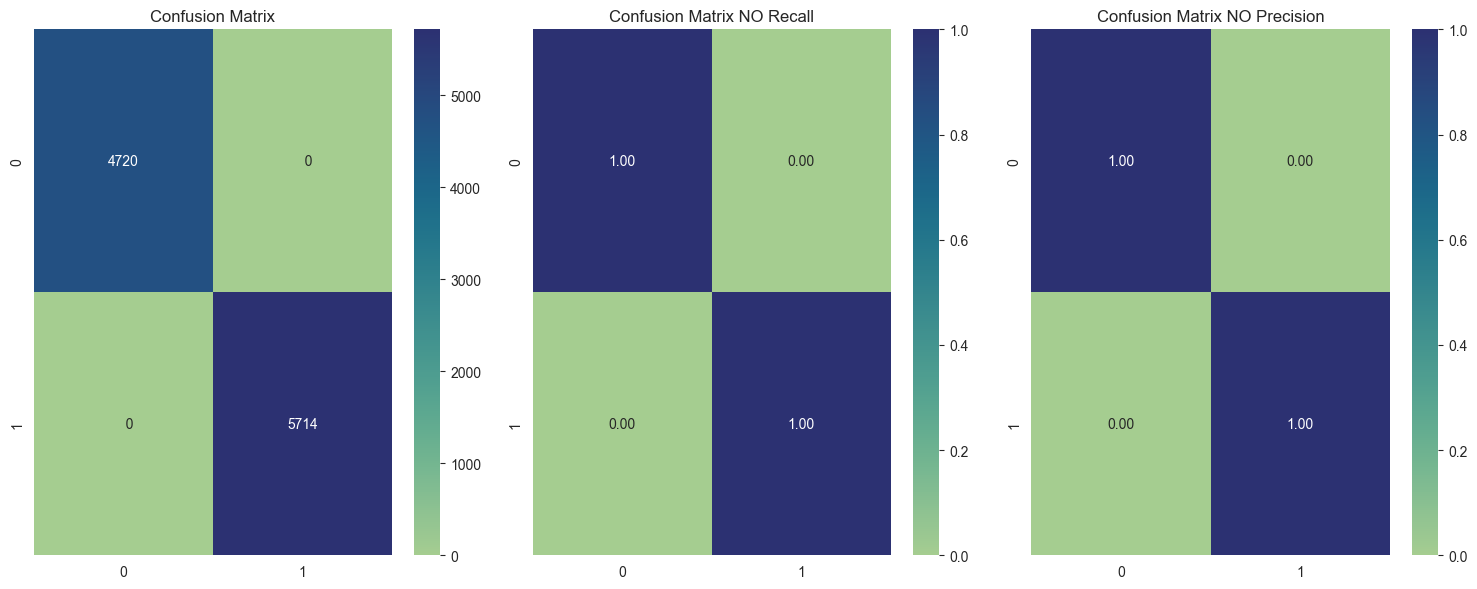

Confusion Matrix (KNN):
 [[4720    0]
 [   0 5714]]

Confusion Matrix (Normalized - Recall):
 [[1. 0.]
 [0. 1.]]

Confusion Matrix (Normalized - Precision):
 [[1. 0.]
 [0. 1.]]


In [31]:
conf_matrix_lgbm_clf = confusion_matrix(y_test_lr3, y_pred_lgbm_clf)

conf_matrix_normalized_recall_lgbm_clf = confusion_matrix(y_test_lr3, y_pred_lgbm_clf, normalize='true')
conf_matrix_normalized_precision_lgbm_clf = confusion_matrix(y_test_lr3, y_pred_lgbm_clf, normalize='pred')


fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.heatmap(conf_matrix_lgbm_clf, annot=True, fmt="4.0f", cmap="crest", ax=axes[0])
axes[0].set_title("Confusion Matrix")
#по recall
sns.heatmap(conf_matrix_normalized_recall_lgbm_clf, annot=True, fmt=".2f", cmap="crest",ax=axes[1])
axes[1].set_title("Confusion Matrix NO Recall")
#по precision
sns.heatmap(conf_matrix_normalized_precision_lgbm_clf, annot=True, fmt=".2f", cmap="crest",ax=axes[2])
axes[2].set_title("Confusion Matrix NO Precision")
plt.tight_layout()
plt.show()

print("Confusion Matrix (KNN):\n", conf_matrix_lgbm_clf)
print("\nConfusion Matrix (Normalized - Recall):\n", conf_matrix_normalized_recall_lgbm_clf)
print("\nConfusion Matrix (Normalized - Precision):\n", conf_matrix_normalized_precision_lgbm_clf)

In [39]:

y_pred_proba_lgbm = rand_search.predict_proba(X_test_prepr_lr3)
auc_lgbm = roc_auc_score(y_test_lr3, y_pred_lgbm_clf)

metrics_data = {
    'Model': ['Lgbm'],
    'Binary Crossentropy': [log_loss(y_test_lr3, y_pred_proba_lgbm)],
    'Accuracy': [accuracy_score(y_test_lr3, y_pred_lgbm_clf)],
    'Precision': [precision_score(y_test_lr3, y_pred_lgbm_clf)],
    'Recall': [recall_score(y_test_lr3, y_pred_lgbm_clf)],
    'F1 Score': [f1_score(y_test_lr3, y_pred_lgbm_clf)],
    'ROC AUC': [auc_lgbm]
}


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


   Model  Binary Crossentropy  Accuracy  Precision    Recall  F1 Score  \
0      Log             0.326110  0.869178   0.853980  0.918096  0.884878   
1      SVC             0.204707  1.000000   1.000000  1.000000  1.000000   
2  SVC_Lin             0.547558  0.765862   0.714211  0.954323  0.816990   

    ROC AUC  
0  0.931558  
1  1.000000  
2  0.897614

# Розв’язати задачу класифікації на датасеті з 4 ЛР, 

використовуючи бустинг-класифікатор [API: 2, зверніть увагу, що необхідно правильно вибрати функцію втрат для мультикласової класифікації]. Обчислити метрики, задані у відповідній лабораторній роботі. Вивести порівняльну таблицю результатів лінійної регресії (кращої з усіх навчених в ЛР 4) та результатів бустинг моделі

In [23]:

lgbm_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

lgbm_clf_mult = LGBMClassifier(objective='multiclass', metric='multi_logloss')
grid_search_lgbm_clf_mult = GridSearchCV(lgbm_clf_mult, lgbm_params, cv=5)
grid_search_lgbm_clf_mult.fit(X_train_prepr_lr4, y_train_lr4)

print("LightGBM Best Params:", grid_search_lgbm_clf_mult.best_params_)
print("LightGBM Best Score:", grid_search_lgbm_clf_mult.best_score_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 1619, number of used features: 12
[LightGBM] [Info] Start training from score -2.385618
[LightGBM] [Info] Start training from score -0.651411
[LightGBM] [Info] Start training from score -0.950214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [25]:
y_pred_clf_mult = grid_search_lgbm_clf_mult.predict(X_test_prepr_lr4)


accuracy_clf_mult = accuracy_score(y_test_lr4, y_pred_clf_mult)
precision_clf_mult = precision_score(y_test_lr4, y_pred_clf_mult, average='weighted', zero_division=0)
recall_clf_mult = recall_score(y_test_lr4, y_pred_clf_mult, average='weighted', zero_division=0)
f1_clf_mult = f1_score(y_test_lr4, y_pred_clf_mult, average='weighted', zero_division=0)

print("Accuracy:", accuracy_clf_mult)
print("Precision:", precision_clf_mult)
print("Recall:", recall_clf_mult)
print("F1 Score:", f1_clf_mult)

# Classification report
print("Classification Report:")
print(classification_report(y_test_lr4, y_pred_clf_mult))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.5237154150197628
Precision: 0.5143311706068063
Recall: 0.5237154150197628
F1 Score: 0.4027404605086662
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.04      0.08        47
           2       0.53      0.95      0.68       264
           3       0.46      0.06      0.11       195

    accuracy                           0.52       506
   macro avg       0.55      0.35      0.29       506
weighted avg       0.51      0.52      0.40       506


                        Accuracy  Precision    Recall  F1 Score
KNN                     0.501976   0.468990  0.501976  0.472361
SGDClassifier           0.531621   0.341996  0.531621  0.378401
DecisionTreeClassifier  0.523715   0.508032  0.523715  0.512730

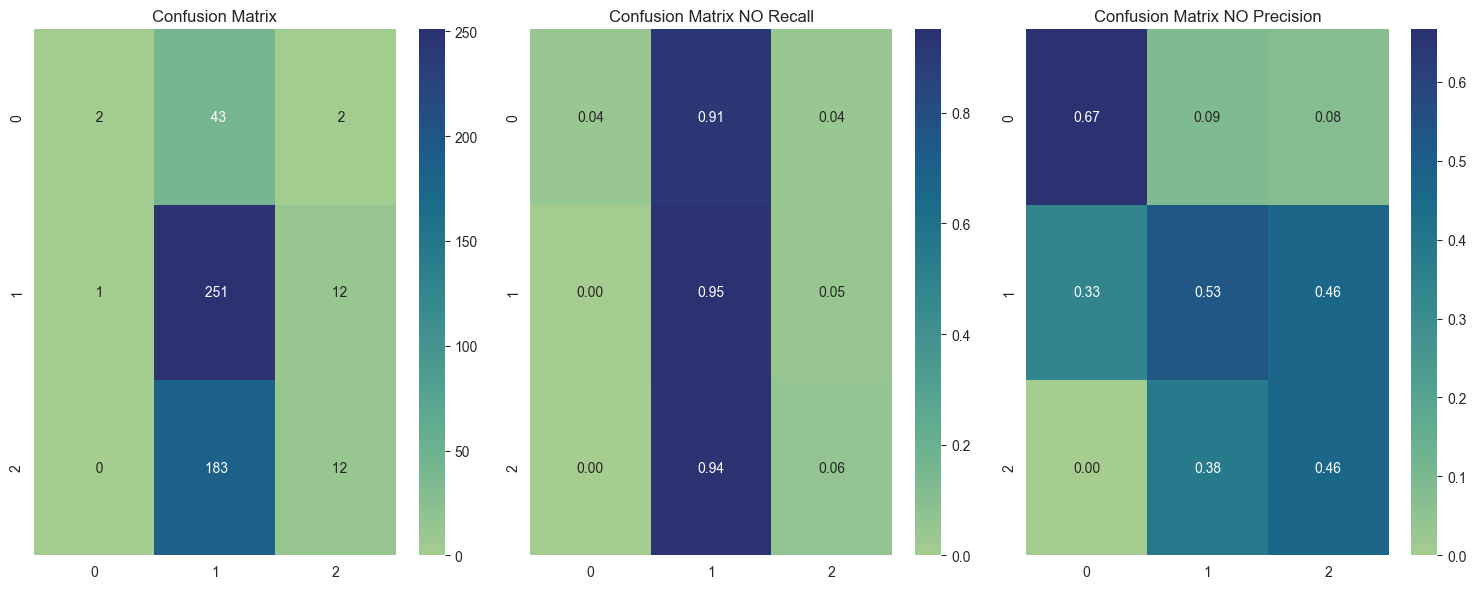

Confusion Matrix (KNN):
 [[  2  43   2]
 [  1 251  12]
 [  0 183  12]]

Confusion Matrix (Normalized - Recall):
 [[0.04255319 0.91489362 0.04255319]
 [0.00378788 0.95075758 0.04545455]
 [0.         0.93846154 0.06153846]]

Confusion Matrix (Normalized - Precision):
 [[0.66666667 0.09014675 0.07692308]
 [0.33333333 0.52620545 0.46153846]
 [0.         0.3836478  0.46153846]]


In [26]:
conf_matrix_clf_mult = confusion_matrix(y_test_lr4, y_pred_clf_mult)

conf_matrix_normalized_recall_clf_mult = confusion_matrix(y_test_lr4, y_pred_clf_mult, normalize='true')
conf_matrix_normalized_precision_clf_mult = confusion_matrix(y_test_lr4, y_pred_clf_mult, normalize='pred')


fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.heatmap(conf_matrix_clf_mult, annot=True, fmt="4.0f", cmap="crest", ax=axes[0])
axes[0].set_title("Confusion Matrix")
#по recall
sns.heatmap(conf_matrix_normalized_recall_clf_mult, annot=True, fmt=".2f", cmap="crest",ax=axes[1])
axes[1].set_title("Confusion Matrix NO Recall")
#по precision
sns.heatmap(conf_matrix_normalized_precision_clf_mult, annot=True, fmt=".2f", cmap="crest",ax=axes[2])
axes[2].set_title("Confusion Matrix NO Precision")
plt.tight_layout()
plt.show()

print("Confusion Matrix (KNN):\n", conf_matrix_clf_mult)
print("\nConfusion Matrix (Normalized - Recall):\n", conf_matrix_normalized_recall_clf_mult)
print("\nConfusion Matrix (Normalized - Precision):\n", conf_matrix_normalized_precision_clf_mult)